<a href="https://colab.research.google.com/github/bdip635/Cytology-Segmentation/blob/main/Training_on_Patches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import re
from PIL import Image
import cv2

# %tensorflow_version 1.x
import tensorflow as tf


import numpy as np
import matplotlib.pyplot as plt
from pylab import *
import os
import sys
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import *


#from tensorflow.keras.engine import Layer
from tensorflow.keras.applications.vgg16 import *
from tensorflow.keras.models import *
#from tensorflow.keras.applications.imagenet_utils import _obtain_input_shape
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Cropping2D, Conv2D, SeparableConv2D
from tensorflow.keras.layers import Input, Add, Dropout, Permute, add
from tensorflow.compat.v1.layers import conv2d_transpose
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

print(tf.__version__)

2.4.0


In [ ]:
main_dir="drive/My Drive/ip_proj/Patches_16"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Benign_dir= os.path.join(main_dir,'Frames/BPno')
Benign_GT_dir= os.path.join(main_dir,'Masks/BPno_GT')

Malignant_dir= os.path.join(main_dir,'Frames/MPno')
Malignant_GT_dir= os.path.join(main_dir,'Masks/MPno_GT')

B_list= sorted(os.listdir(Benign_dir))
BGT_list= sorted(os.listdir(Benign_GT_dir))

M_list= sorted(os.listdir(Malignant_dir))
MGT_list= sorted(os.listdir(Malignant_GT_dir))

total_B_frames= len(B_list)
total_B_masks= len(BGT_list)

total_M_frames= len(M_list)
total_M_masks= len(MGT_list)

print([total_B_frames,total_B_masks,total_M_frames,total_M_masks])

[2032, 2032, 1360, 1360]


In [ ]:
height=360
width=480
batch_size=20
seed=1

In [ ]:
N=20
k=18

B_images= np.zeros((N,height,width,3))
M_images= np.zeros((N,height,width,3))
B_masks= np.zeros((N,height,width,3))
M_masks= np.zeros((N,height,width,3))

for i in range(N):
  B_image_path= os.path.join(Benign_dir,B_list[i])
  B_images[i]= load_img(B_image_path, color_mode='rgb')
  B_images[i]= (np.asarray(B_images[i]).copy())/255.0

  B_mask_path= os.path.join(Benign_GT_dir,BGT_list[i])
  B_masks[i]= load_img(B_mask_path, color_mode='rgb')
  B_masks[i]= (np.asarray(B_masks[i]).copy())

  M_image_path= os.path.join(Malignant_dir,M_list[i])
  M_images[i]= load_img(M_image_path, color_mode='rgb')
  M_images[i]= (np.asarray(M_images[i]).copy())/255.0

  M_mask_path= os.path.join(Malignant_GT_dir,MGT_list[i])
  M_masks[i]= load_img(M_mask_path, color_mode='rgb')
  M_masks[i]= (np.asarray(M_masks[i]).copy())

fig,ax= plt.subplots(1,2)

ax[0].imshow(M_images[k])
ax[1].imshow(M_masks[k])

KeyboardInterrupt: ignored

In [ ]:
frames_pointing_dir= os.path.join(main_dir,'Frames')
masks_pointing_dir= os.path.join(main_dir,'Masks')

print(os.listdir(frames_pointing_dir))
print(os.listdir(masks_pointing_dir))

['BPno', 'MPno']
['BPno_GT', 'MPno_GT']


In [ ]:
id2code= {0: (255,0,0),
          1:(0,255,0), 
          2:(0,0,255), 
          3:(255,0,255), 
          4:(255,255,255)
          }
print(id2code)

{0: (255, 0, 0), 1: (0, 255, 0), 2: (0, 0, 255), 3: (255, 0, 255), 4: (255, 255, 255)}


In [ ]:
def rgb_to_onehot(rgb_image, colormap = id2code):
    '''Function to one hot encode RGB mask labels
        Inputs: 
            rgb_image - image matrix (height x width x 3 dimension numpy ndarray)
            colormap - dictionary of color to label id
        Output: One hot encoded image of dimensions (height x width x num_classes) where num_classes = len(colormap)
    '''
    num_classes = len(colormap)
    shape = rgb_image.shape[:2]+(num_classes,)
    encoded_image = np.zeros(shape)
    for i, cls in enumerate(colormap):
        encoded_image[:,:,i] = np.all(rgb_image.reshape( (-1,3) ) == colormap[i], axis=1).reshape(shape[:2])
    return encoded_image


def onehot_to_rgb(onehot, colormap = id2code):
    '''Function to decode encoded mask labels
        Inputs: 
            onehot - one hot encoded image matrix (height x width x num_classes)
            colormap - dictionary of color to label id
        Output: Decoded RGB image (height x width x 3) 
    '''
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )
    for k in colormap.keys():
        output[single_layer==k] = colormap[k]
    return np.uint8(output)

<class 'numpy.ndarray'>


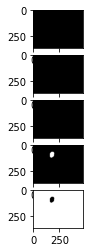

In [ ]:
one_hot= rgb_to_onehot(M_masks[k])

fig,ax= plt.subplots(5,1)

for i in range(5):
  ax[i].imshow(one_hot[:,:,i],'gray')

print(type(one_hot[:,:,1]))

In [ ]:
frame_gen_args = dict(rotation_range=45,
                      width_shift_range=0.1,
                      height_shift_range=0.1,
                      shear_range=0.2,
                      zoom_range=0.2,
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect',
                      validation_split= 0.2)

mask_gen_args = dict(rotation_range=45,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.2,
                     zoom_range=0.2,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect',
                     validation_split= 0.2)

frame_datagen= ImageDataGenerator(**frame_gen_args)
mask_datagen = ImageDataGenerator(**mask_gen_args)


In [ ]:
def Train_AugmentGenerator(seed = 1, batch_size = batch_size):
    '''Train Image data generator
        Inputs: 
            seed - seed provided to the flow_from_directory function to ensure aligned data flow
            batch_size - number of images to import at a time
        Output: Decoded RGB image (height x width x 3) 
    '''
    train_frame_generator = frame_datagen.flow_from_directory(
        frames_pointing_dir,
        target_size=(height, width),
        batch_size=batch_size,
        subset='training',
        seed= seed)
    
    train_mask_generator = mask_datagen.flow_from_directory(
        masks_pointing_dir,
        target_size=(height, width),
        batch_size=batch_size,
        subset='training',
        seed= seed)    
    
    while True:
        X1i = train_frame_generator.next() 
        X2i = train_mask_generator.next()
        mask_encoded = [rgb_to_onehot(X2i[0][x,:,:,:], id2code) for x in range(X2i[0].shape[0])]
      
        yield X1i[0],  np.asarray(mask_encoded)

In [ ]:
def Val_Augment_Generator(seed = 1, batch_size = batch_size):
    '''Validation Image data generator
        Inputs: 
            seed - seed provided to the flow_from_directory function to ensure aligned data flow
            batch_size - number of images to import at a time
        Output: Decoded RGB image (height x width x 3) 
    '''
    val_frame_generator = frame_datagen.flow_from_directory(
        frames_pointing_dir,
        target_size=(height,width),
        batch_size= batch_size,
        subset='validation',
        seed= seed)

    val_mask_generator = mask_datagen.flow_from_directory(
        masks_pointing_dir,
        target_size=(height,width),
        batch_size= batch_size,
        subset='validation',
        seed= seed)
    
    while True:
        X1i = val_frame_generator.next()
        X2i = val_mask_generator.next()
        
        #One hot encoding RGB images
        mask_encoded = [rgb_to_onehot(X2i[0][x,:,:,:], id2code) for x in range(X2i[0].shape[0])]
        
        yield X1i[0], np.asarray(mask_encoded)

In [ ]:
t_gen=Train_AugmentGenerator()
batch_img,batch_mask = next(t_gen)

Found 2714 images belonging to 2 classes.
Found 2714 images belonging to 2 classes.


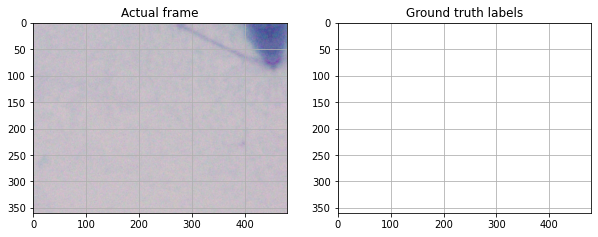

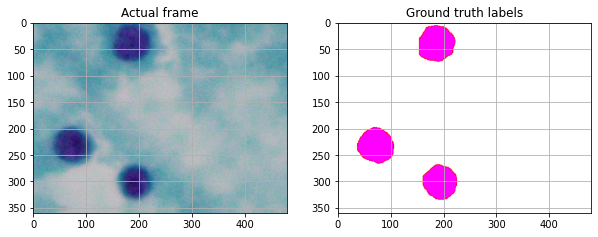

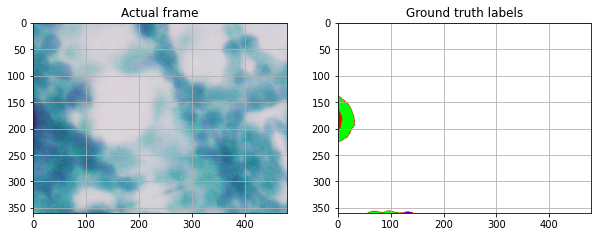

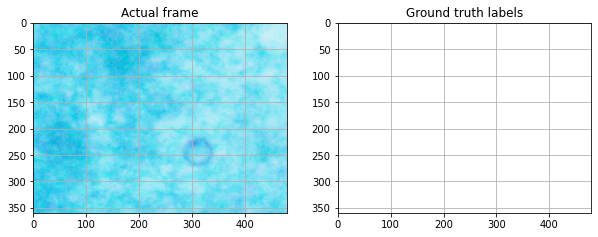

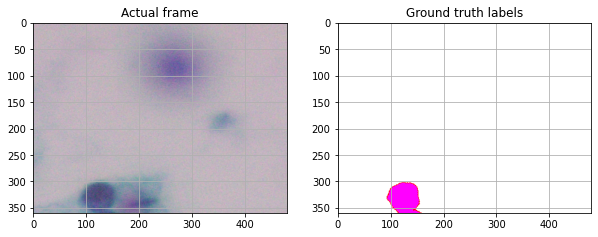

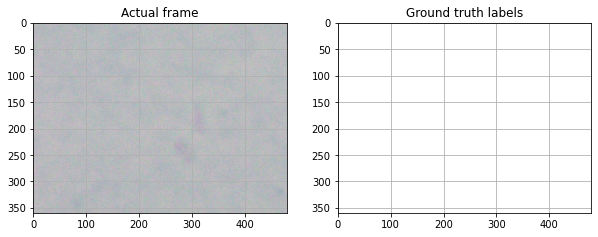

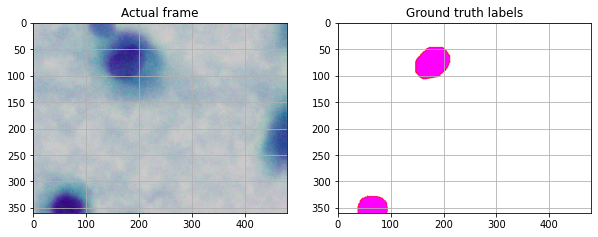

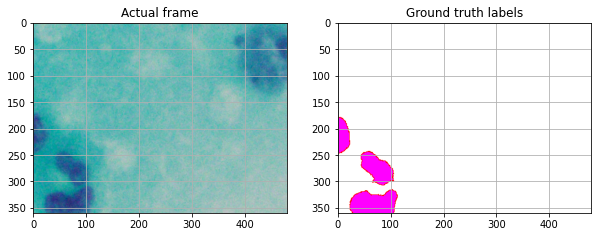

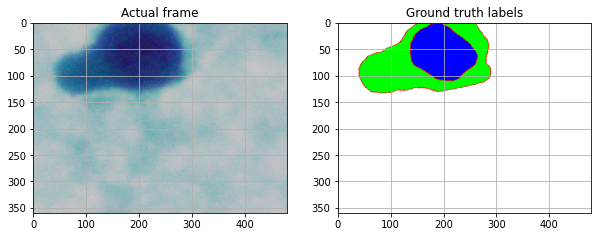

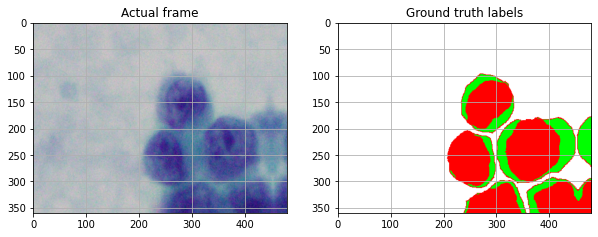

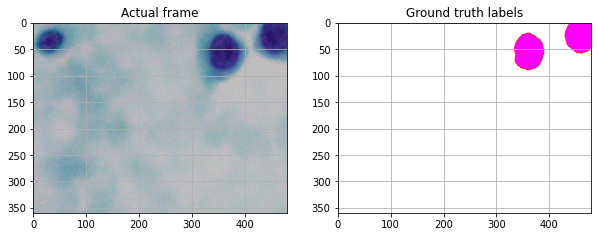

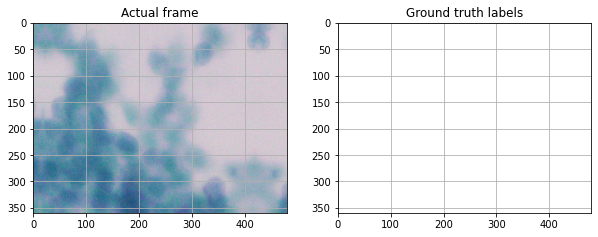

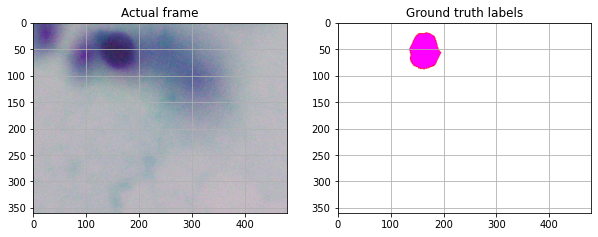

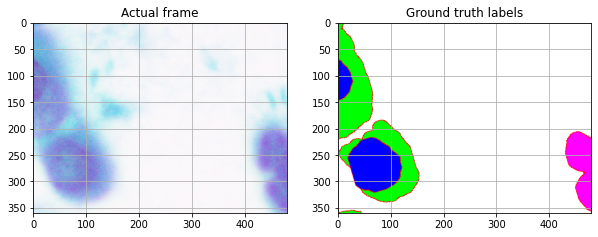

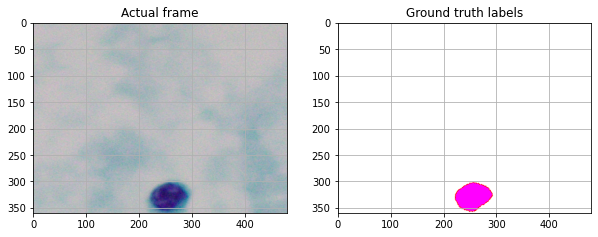

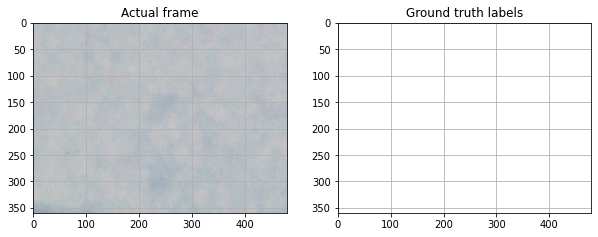

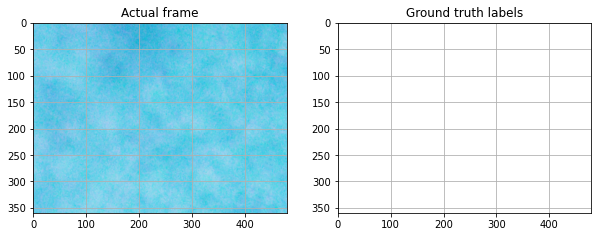

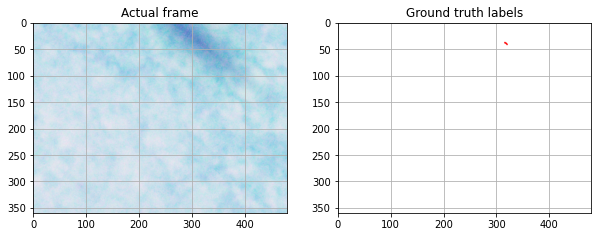

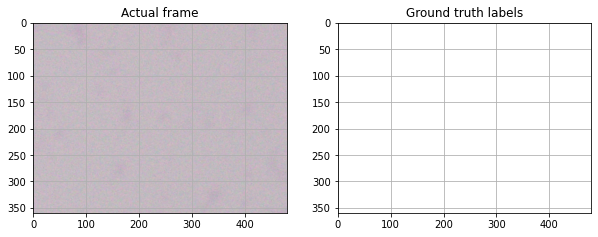

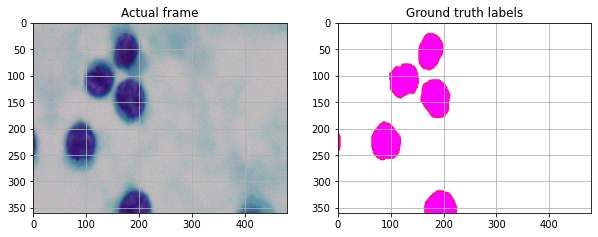

In [ ]:
for i in range(0,np.shape(batch_mask)[0]):
    
    fig = plt.figure(figsize=(10,4))
    
    ax1 = fig.add_subplot(1,2,1)
    ax1.set_title('Actual frame')
    ax1.imshow(batch_img[i].astype(int))
    ax1.grid(b=None)
    
    
    ax2 = fig.add_subplot(1,2,2)
    ax2.set_title('Ground truth labels')
    ax2.imshow(onehot_to_rgb(batch_mask[i]))
    ax2.grid(b=None)
    
    plt.show()

In [ ]:

def model_UNET(h,w,filters=32,pi=0.7):

  input_layer=Input(shape=(h,w,3))
  c1=Conv2D(filters*1, kernel_size=(7,7), padding='same', activation='relu')(input_layer)
  c1=Conv2D(filters*1, kernel_size=(7,7), padding='same', activation='relu')(c1)
  c1=BatchNormalization()(c1)
  p1=MaxPooling2D(pool_size=(2,2), strides=2)(c1)
  p1=Dropout(rate=pi)(p1)             # (180,240,16)

  c2=Conv2D(filters*2, kernel_size=(7,7), padding='same', activation='relu')(p1)
  c2=Conv2D(filters*2, kernel_size=(7,7), padding='same', activation='relu')(c2)    # (180,240,128)
  c2=BatchNormalization()(c2)
  p2=MaxPooling2D(pool_size=(2,2), strides=2)(c2)
  p2=Dropout(rate=pi)(p2)             # (90,120,32)


  c3=Conv2D(filters*4, kernel_size=(7,7), padding='same', activation='relu')(p2)
  c3=Conv2D(filters*4, kernel_size=(7,7), padding='same', activation='relu')(c3)    # (90,120,256)
  c3=BatchNormalization()(c3)
  p3=MaxPooling2D(pool_size=(2,2), strides=2)(c3)
  p3=Dropout(rate=pi)(p3)            # (45,60,64)


  c4=Conv2D(filters*8, kernel_size=(7,7), padding='same', activation='relu')(p3)
  c4=Conv2D(filters*8, kernel_size=(7,7), padding='same', activation='relu')(c4)
  c4=BatchNormalization()(c4)        # (45,60,128)

  u7= Conv2DTranspose(filters*4, kernel_size=(7,7), strides=(2,2), padding='same')(c4)  # (90,120,256)
  u7= concatenate([u7,c3])

  c5= Conv2D(filters*4, kernel_size=(7,7), padding='same', activation='relu')(u7)
  c5= Conv2D(filters*4, kernel_size=(7,7), padding='same', activation='relu')(c5)
  c5= BatchNormalization()(c5)
  c5= Dropout(rate=pi)(c5)

  u8= Conv2DTranspose(filters*2, kernel_size=(7,7), strides=(2,2), padding='same')(c5)
  u8= concatenate([u8,c2])

  c6= Conv2D(filters*4, kernel_size=(7,7), padding='same', activation='relu')(u8)
  c6= Conv2D(filters*4, kernel_size=(7,7), padding='same', activation='relu')(c6)
  c6= BatchNormalization()(c6)
  c6= Dropout(rate=pi)(c6)

  u9= Conv2DTranspose(filters*1, kernel_size=(7,7), strides=(2,2), padding='same')(c6)
  u9= concatenate([u9,c1])

  c7= Conv2D(filters*1, kernel_size=(7,7), padding='same', activation='relu')(u9)
  c7= Conv2D(filters*1, kernel_size=(7,7), padding='same', activation='relu')(c7)
  c7= BatchNormalization()(c7)
  c7= Dropout(rate=pi)(c7)

  output= Conv2D(5, kernel_size=(1,1), padding='same', activation='relu')(c7)

  unet=Model(inputs=[input_layer], outputs=[output])
  return unet
  #UNet architecture

In [ ]:
model= model_UNET(height,width)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 360, 480, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 360, 480, 32) 4736        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 360, 480, 32) 50208       conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 360, 480, 32) 128         conv2d_1[0][0]                   
______________________________________________________________________________________________

In [ ]:
def dice_loss_modified(y_true,y_pred):
  smooth= 1e-3
  eps=1e-3

  y_true_shape= tf.shape(y_true)
  pred_tensor= tf.nn.softmax(y_pred)
  total_pixels_per_ch= tf.cast(y_true_shape[1]*y_true_shape[2], dtype= tf.float32)

  y_true = tf.reshape(y_true, [-1, y_true_shape[1]*y_true_shape[2], y_true_shape[3]])
  y_pred = tf.reshape(pred_tensor, [-1, y_true_shape[1]*y_true_shape[2], y_true_shape[3]])

  multed = tf.reduce_sum(y_true * y_pred, axis=1)
  summed = tf.reduce_sum(y_true + y_pred, axis=1)

  # counts = tf.reduce_sum(y_true, axis=1)
  # weightage = 1.-counts/total_pixels_per_ch
  # weightage = tf.where(tf.math.is_finite(weightage), weightage, eps)

  numerators = tf.reduce_sum(multed, axis=-1)
  denom = tf.reduce_sum(summed, axis=-1)
  dices = 1. - 2. * (numerators+smooth)/ (denom+smooth)
  loss = tf.reduce_mean(dices)
  return loss

In [ ]:
y1= 3*tf.ones(shape=(32,360,480,5))
y2= 0.2*tf.ones(shape=(32,360,480,5))

ws= dice_loss_modified(y1,y2)

print(ws)

tf.Tensor(0.62499994, shape=(), dtype=float32)


In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    return 1- dice_loss_modified(y_true,y_pred)

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


In [ ]:
opt=Adam(learning_rate=7.5e-6)
model.compile(optimizer=opt, loss= dice_loss_modified, metrics=['acc',dice_coef, recall_m, precision_m])

In [ ]:
t_gen=Train_AugmentGenerator()
batch_img,batch_mask = next(t_gen)

for i in range(0,np.shape(batch_mask)[0]):
    
    fig = plt.figure(figsize=(10,4))
    
    ax1 = fig.add_subplot(1,2,1)
    ax1.set_title('Actual frame')
    ax1.imshow(batch_img[i].astype(int))
    ax1.grid(b=None)
    
    
    ax2 = fig.add_subplot(1,2,2)
    ax2.set_title('Ground truth labels')
    ax2.imshow(onehot_to_rgb(batch_mask[i]))
    ax2.grid(b=None)
    
    plt.show()

In [ ]:
num_epochs = 100
total_train_ims= 3053
total_val_ims= 339
steps_per_epoch= total_train_ims//batch_size
val_steps= total_val_ims//batch_size

In [ ]:
weights_load_file=os.path.join(main_dir,'WEIGHTS_NEW7.hdf5')
weights_file=os.path.join(main_dir,'WEIGHTS_NEW6.hdf5')
model.load_weights(weights_load_file)

checkpoint = ModelCheckpoint(weights_file, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, 
                                   patience=10, 
                                   verbose=1, mode='min', min_delta=0.0001, cooldown=2, min_lr=1e-15)

callbacks = [checkpoint]

In [ ]:
history= model.fit(
                   Train_AugmentGenerator(),
                   epochs= num_epochs,
                   callbacks= callbacks,
                   validation_data= Val_Augment_Generator(),
                   shuffle= True,
                   steps_per_epoch= steps_per_epoch,
                   validation_steps= val_steps)

Found 2714 images belonging to 2 classes.
Found 2714 images belonging to 2 classes.
Epoch 1/100
152/152 [==============================] - ETA: 0s - loss: 0.0199 - acc: 0.9790 - dice_coef: 0.9801 - recall_m: 0.9871 - precision_m: 0.6440 Found 678 images belonging to 2 classes.
Found 678 images belonging to 2 classes.
152/152 [==============================] - 2106s 14s/step - loss: 0.0199 - acc: 0.9790 - dice_coef: 0.9801 - recall_m: 0.9871 - precision_m: 0.6440 - val_loss: 0.0222 - val_acc: 0.9767 - val_dice_coef: 0.9778 - val_recall_m: 0.9814 - val_precision_m: 0.9625

Epoch 00001: val_loss improved from inf to 0.02223, saving model to drive/My Drive/ip_proj/Patches_16/WEIGHTS_NEW6.hdf5
Epoch 2/100
152/152 [==============================] - 732s 5s/step - loss: 0.0193 - acc: 0.9796 - dice_coef: 0.9807 - recall_m: 0.9875 - precision_m: 0.6425 - val_loss: 0.0242 - val_acc: 0.9746 - val_dice_coef: 0.9758 - val_recall_m: 0.9801 - val_precision_m: 0.9576

Epoch 00002: val_loss did not imp

In [ ]:
weights_save_file= os.path.join(main_dir,'WEIGHTS_NEW8.hdf5')
model.save_weights(weights_save_file)